In [1]:
import ROOT
import sys

Welcome to JupyROOT 6.26/00


## Part 1: generation and basics

In this case, we want an example like this, i.e. an exponential background and a peaked (e.g. Gaussian) distribution:
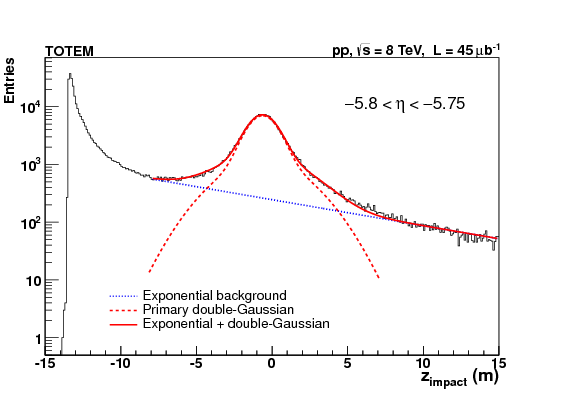

1.1 Fit variables: you define the random variables involved:
- mass (x axis)
- number of events n


In [2]:
mass = ROOT.RooRealVar("mass","mass plot",0,1000,"GeV")  
nsignal=250
nbackground=1000
nev = ROOT.RooRealVar("n","n events",nsignal+nbackground,0,2000)      

1.2 Parameters of the distribution:
- number of signal events
- number of background events
- function parameters: mean, width of the gaussian, slope of the exponential (lambda)

In [3]:
signal = ROOT.RooRealVar("signal","signal events",nsignal,0,2000) 
background = ROOT.RooRealVar("background","signal events",nbackground,0,2000) 
    
mean = ROOT.RooRealVar("mean","signal mean",200,0,1000)
sigma = ROOT.RooRealVar("sigma","signal sigma",50,0,1000) 
mean2 = ROOT.RooRealVar("mean","signal mean",0,-1000,1000)
sigma2 = ROOT.RooRealVar("sigma","signal sigma",120,0,1000) 
lam = ROOT.RooRealVar("lam","lam",-0.01,-5,0)

#Computing total number of events as new "composite" variable
totevents = ROOT.RooFormulaVar("total_events", "signal+background", ROOT.RooArgList(signal,background)) 

We define two pdfs which are already included in the ROOT libraries   

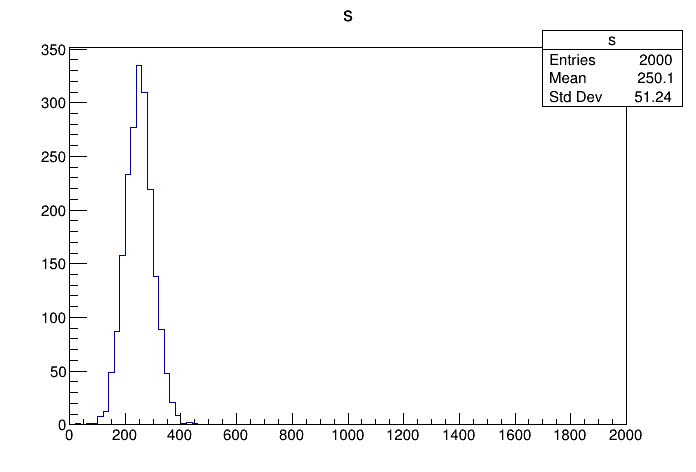

In [4]:
h1 = ROOT.TH1F("s","s",100,0,2000)
f1=ROOT.TF1("gaus","gaus",0,2000)
f1.SetParameters(1,250,50)
h1.FillRandom("gaus",2000)
c1=ROOT.TCanvas("c1")
h1.Draw()
c1.Draw()

In [5]:
dh = ROOT.RooDataHist("dh", "dh", ROOT.RooArgList(mass), Import=(h1))
SignalHistoShape= ROOT.RooHistPdf("sighisto","signal histo pdf",mass,dh)

In [6]:
BkgShape = ROOT.RooExponential("expo","Roofit Exponential function",mass,lam)#Background exponential pdf, 

SigShape = ROOT.RooGaussian("gauss","Roofit Gaussian function",mass, mean,sigma)#Signal gaussian pdf, already normalized
SigShape2 = ROOT.RooGaussian("gauss","Roofit Gaussian function",mass, mean2,sigma2)#Signal gaussian pdf, already normalized

TotalSigShape =ROOT.RooAddPdf("totalsig","Total signal considering two gaussians",ROOT.RooArgList(SigShape,SigShape2))

[#0] WARNING:InputArguments -- The parameter 'sigma' with range [0, 1000] of the RooGaussian 'gauss' exceeds the safe range of (0, inf). Advise to limit its range.
[#0] WARNING:InputArguments -- The parameter 'sigma' with range [0, 1000] of the RooGaussian 'gauss' exceeds the safe range of (0, inf). Advise to limit its range.
[#0] ERROR:InputArguments -- RooAddPdf::RooAddPdf(totalsig) pdf gauss is not extendable, ignored
[#0] ERROR:InputArguments -- RooAddPdf::RooAddPdf(totalsig) pdf gauss is not extendable, ignored


1.2 Generation of MC events. We first generate a number of events:

We take the *variable* (nev) and generate according to the *parameter* (s+b=totevents)

In [7]:
ExpEvents = ROOT.RooPoisson("pois","Total number of events",nev,totevents) 

In [8]:
sum_pdf = ROOT.RooAddPdf("sumPDF","Total s+b PDF",ROOT.RooArgList(SignalHistoShape,BkgShape),ROOT.RooArgList(signal,background))
prod_sum_pdf = ROOT.RooProdPdf("extPDF","Total s+b PDF with nevents",ROOT.RooArgList(sum_pdf,ExpEvents))

In [9]:
total_events=prod_sum_pdf.generate(ROOT.RooArgSet(mass,nev))
BinnedEvents=total_events.binnedClone()#the equivalent but divided in bins
#BinnedEvents=total_events.binnedClone()#the equivalent but divided in bins

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file exampleEvents.png has been created


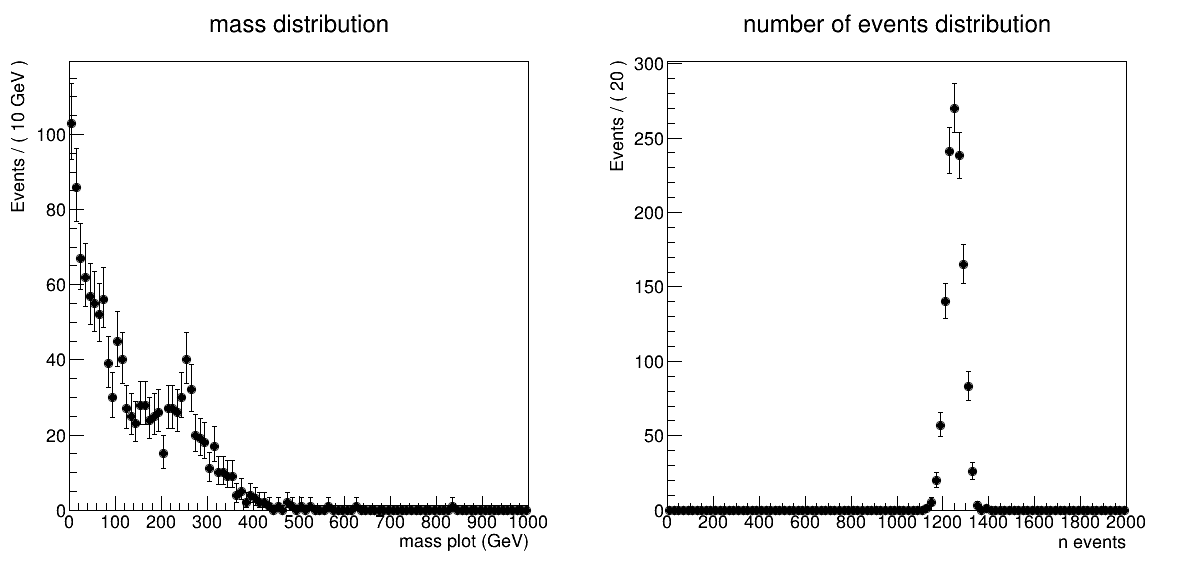

In [10]:
    
#Plotting routines: we make a canvas
c1=ROOT.TCanvas("c1","c1",50,50,1200,600)
# divided in two pieces
c1.Divide(2,1)
#First one
c1.cd(1)
#We create a plot from the first random variable
frame = mass.frame(ROOT.RooFit.Title("mass distribution"))
BinnedEvents.plotOn(frame)
frame.Draw()
#We create a plot from the second random variable
framenev = nev.frame(ROOT.RooFit.Title("number of events distribution"))
c1.cd(2)
BinnedEvents.Clone().plotOn(framenev)
framenev.Draw()
c1.Draw()
c1.SaveAs("exampleEvents.png")    

In [11]:
#Let's generate a mass distribution:
total_events=prod_sum_pdf.generate(ROOT.RooArgSet(mass))
BinnedEvents=total_events.binnedClone()#the equivalent but divided in bins

In [12]:
#And fit it:
prod_sum_pdf.fitTo(total_events, ROOT.RooFit.Extended(1))#pdf . fit to (dataset, options) 

<cppyy.gbl.RooFitResult object at 0x(nil)>

[#1] INFO:Minimization --  Including the following constraint terms in minimization: (pois)
[#1] INFO:Minimization -- The global observables are not defined , normalize constraints with respect to the parameters (background,lam,signal)
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_extPDF_extPDFData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (sighisto)
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (expo)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 background   1.00000e+03  2.00000e+02    0.00000e+00  2.00000e+03
     2 lam         -1.00000e-02  5.

[#1] INFO:Plotting -- RooAbsPdf::plotOn(extPDF) directly selected PDF components: (expo)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(extPDF) indirectly selected PDF components: (sumPDF)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(extPDF) directly selected PDF components: (sighisto)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(extPDF) indirectly selected PDF components: (sumPDF)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file exampleFit.png has been created


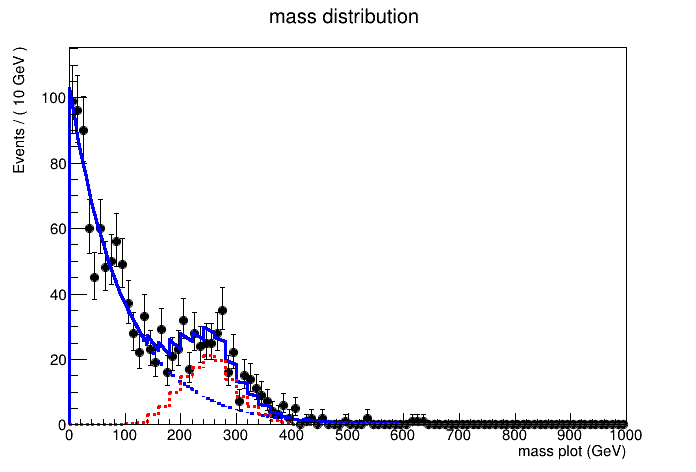

In [13]:
#Plotting fit results:
#We create a plot from the first random variable
frame = mass.frame(ROOT.RooFit.Title("mass distribution"))
BinnedEvents.plotOn(frame)

prod_sum_pdf.plotOn(frame)
bkg_arg = ROOT.RooArgSet(BkgShape)
sig_arg = ROOT.RooArgSet(SignalHistoShape)

prod_sum_pdf.plotOn(frame,ROOT.RooFit.Components(bkg_arg), ROOT.RooFit.LineStyle(ROOT.kDotted) ) 
prod_sum_pdf.plotOn(frame,ROOT.RooFit.Components(sig_arg), ROOT.RooFit.LineStyle(ROOT.kDashed),ROOT.RooFit.LineColor(ROOT.kRed) ) 

c1 = ROOT.TCanvas("c1","Mass fit")
frame.Draw()
#We create a plot from the second random variable
framenev = nev.frame(ROOT.RooFit.Title("number of events distribution"))

c1.Draw()
c1.SaveAs("exampleFit.png")    

In [14]:
#Now let's save the different components of the fit:
w = ROOT.RooWorkspace("ws")
getattr(w,'import')(total_events)
getattr(w,'import')(prod_sum_pdf)
fout = ROOT.TFile("WorkspaceFile.root","RECREATE")#Open per non modificarlo, new per crearlo da zero se non c'è,Update per modificarlo senza sovrascriverlo
w.Write()
fout.Close()

[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing dataset extPDFData
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::mass
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing dataset dh
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooProdPdf::extPDF
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooAddPdf::sumPDF
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooHistPdf::sighisto
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::signal
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooExponential::expo
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::lam
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::background
[#1] INFO:Caching -- RooExpensiveObjectCache::importCache() importing cache object pois_Int[background,signal] associated with object pois
[#1] INFO:ObjectHandling -- RooWorkspace::impor

In [15]:
print("Doing part 2: fit sanity checks")
#Part 2.1: let's extract the workspace!
fin = ROOT.TFile("WorkspaceFile.root")
ws = fin.Get("ws")#NOTE: Root saves files with the "Name" field!!!
ws.Print()
#  return

Doing part 2: fit sanity checks

RooWorkspace(ws) ws contents

variables
---------
(background,lam,mass,n,signal)

p.d.f.s
-------
RooExponential::expo[ x=mass c=lam ] = 0.986072
RooProdPdf::extPDF[ sumPDF * pois ] = 0.00887976
RooPoisson::pois[ x=n mean=total_events ] = 0.0112864
RooHistPdf::sighisto[ pdfObs=(mass) ] = 0
RooAddPdf::sumPDF[ signal * sighisto + background * expo ] = 0.786764

functions
--------
RooFormulaVar::total_events[ actualVars=(signal,background) formula="x[0]+x[1]" ] = 1248.5

datasets
--------
RooDataSet::extPDFData(mass)

embedded datasets (in pdfs and functions)
-----------------------------------------
RooDataHist::dh(mass)

embedded precalculated expensive components
-------------------------------------------
uid = 0 key=pois_Int[background,signal] value=RooDouble::1264.000000 parameters=( n=1263.12 )


In [16]:
print(ws.pdf("sumPDF"))
print(ws.pdf("gauss"))
print(ws.pdf("expo"))
print(ws.var("signal"))

RooAddPdf::sumPDF[ signal * sighisto + background * expo ] = 0.786764

<cppyy.gbl.RooAbsPdf object at 0x(nil)>
RooExponential::expo[ x=mass c=lam ] = 0.986072

RooRealVar::signal = 252.35 +/- 24.3161  L(0 - 2000) 



In [17]:
#Now let's make the pseudoexperiments:
mc_study = ROOT.RooMCStudy(ws.pdf("sumPDF"), ROOT.RooArgSet(ws.var("mass")), ROOT.RooFit.Extended(1), ROOT.RooFit.FitOptions(ROOT.RooFit.Save(1)))
mc_study.generateAndFit(200)#performs both generation and fit 
          
frame_nll = mc_study.plotNLL(ROOT.RooFit.Bins(40))
frame_sig = mc_study.plotParam(ws.var("signal"),ROOT.RooFit.Bins(40))
frame_err = mc_study.plotError(ws.var("signal"),ROOT.RooFit.Bins(40))
frame_pulls = mc_study.plotPull(ws.var("signal"),ROOT.RooFit.Bins(40),ROOT.RooFit.FitGauss(1))

[#0] PROGRESS:Generation -- RooMCStudy: now generating 1250 events
[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minimization -- createConstraintTerm: caching constraint set under name CACHE_CONSTR_OF_PDF_sumPDF_FOR_OBS_mass with 0 entries
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (sighisto)
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (expo)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 background   9.96150e+02  3.65335e+01    0.00000e+00  2.00000e+03
     2 lam         -1.02998e-02  4.48918e-04   -5.00000e+00  0.00000e+00
     3 signal       2.52350

In [22]:
%jsroot on
c1=ROOT.TCanvas("stattests","Statistical Tests",50,50,1000,1000)

c1.Divide(2,2)
c1.cd(1)
frame_nll.Draw()
c1.cd(2)
frame_sig.Draw()
c1.cd(3)
frame_err.Draw()
c1.cd(4)
frame_pulls.Draw()

c1.Draw()
c1.SaveAs("StatisticalTests.png")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: stattests
Info in <TCanvas::Print>: png file StatisticalTests.png has been created
